# Digit Recognition with MNIST Dataset using PyTorch

In [21]:
# Importing Pytorch and Necessary Modules.

%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [22]:
# Loading Dataset.

train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

In [23]:
train_data = train.train_data
print(type(train_data))
train_data = train.transform(train_data.numpy())
print(type(train_data))

print(train_data.shape)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([28, 60000, 28])


In [24]:
# Metrics.

train_data = train.train_data
train_data = train.transform(train_data.numpy())

print(' -> Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' -> Tensor Shape:', train.train_data.size())
print(' -> Transformed Shape:', train_data.size())

 -> Numpy Shape: (60000, 28, 28)
 -> Tensor Shape: torch.Size([60000, 28, 28])
 -> Transformed Shape: torch.Size([28, 60000, 28])


In [25]:
# Designing Neural Network (Linear with Backpropogation)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        # Linear Layer
        
        self.fc1 = nn.Linear(784, 548)
        self.bc1 = nn.BatchNorm1d(548)
        
        self.fc2 = nn.Linear(548, 252)
        self.bc2 = nn.BatchNorm1d(252)
        
        self.fc3 = nn.Linear(252, 10)
        
        
    def forward(self, x):
        x = x.view((-1, 784))
        
        # Calling Initial Layers 
        h = self.fc1(x)
        h = self.bc1(h)
        
        # Defining Activation Function
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        # Calling Second Layers 
        
        h = self.fc2(h)
        h = self.bc2(h)
        
        # Second Layer Activation Function
        
        h = F.relu(h)
        h = F.dropout(h, p=0.2, training=self.training)
        
        h = self.fc3(h)
        out = F.log_softmax(h, dim = 1)
        return out

# Creating a model.
model = Model()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [26]:
# Model Architecture
print(model)

# Adam Optimizer
print(optimizer)

Model(
  (fc1): Linear(in_features=784, out_features=548, bias=True)
  (bc1): BatchNorm1d(548, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=548, out_features=252, bias=True)
  (bc2): BatchNorm1d(252, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=252, out_features=10, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


In [27]:
model.train()

Model(
  (fc1): Linear(in_features=784, out_features=548, bias=True)
  (bc1): BatchNorm1d(548, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=548, out_features=252, bias=True)
  (bc2): BatchNorm1d(252, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=252, out_features=10, bias=True)
)

In [28]:
dataloader_args = dict(shuffle=True, batch_size=64,num_workers=1, pin_memory=True)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

In [29]:
# Training model.

losses = []
for epoch in range(6):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data), Variable(target)
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.data[0])
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.data[0]), 
                end='')
            
    print()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


 Train Epoch: 0 [57664/60000 (96%)]	Loss: 0.203466
 Train Epoch: 1 [57664/60000 (96%)]	Loss: 0.181349
 Train Epoch: 2 [57664/60000 (96%)]	Loss: 0.094402
 Train Epoch: 3 [57664/60000 (96%)]	Loss: 0.047231
 Train Epoch: 4 [57664/60000 (96%)]	Loss: 0.045122
 Train Epoch: 5 [57664/60000 (96%)]	Loss: 0.248005


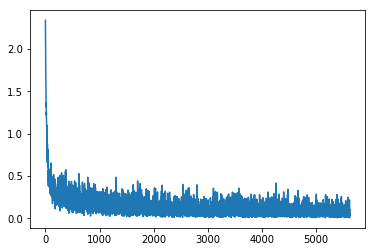

In [30]:
plt.plot(losses)

plt.savefig("losidtic.png", trasparent = True)

In [12]:
# Accuracy and Evalution of trained model.

evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
evaluate_y = Variable(test_loader.dataset.test_labels)


output = model(evaluate_x)
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum()/d.size()[0]

print('Accuracy:', accuracy)

Accuracy: tensor(0)


In [13]:
# Outputs in Numbers for testdataset.

print(pred)

tensor([ 7,  2,  1,  ...,  4,  5,  6])


torch.Size([10000, 28, 28])
<class 'torch.Tensor'>
<class 'numpy.ndarray'>


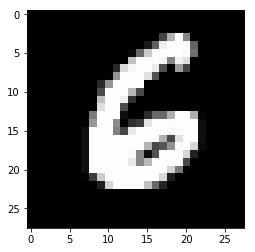

In [14]:
# Coverting Pixel Array to Image

print(evaluate_x.shape)
img = evaluate_x[131]
print(type(img))
img = img.data.cpu().numpy()
print(type(img))
plt.imshow((img).reshape(28,28), cmap=cm.gray)